In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square
from scipy.integrate import quad
from numpy import sqrt, exp, pi, cos, sin, log
from scipy.stats import norm
import pandas as pd
from time import perf_counter
from tqdm.notebook  import tqdm

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')
np.seterr(all = 'ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

# Part 1
----------------------------------------------------------------
from Medium.com : https://medium.com/@alexander.tsoskounoglou/pricing-options-with-fourier-series-p1-5bf60443ba0c 

# Introduciton

For a function $f(x)$ with for a range a,b we can transform it as:
$$\begin{align*}
& f(x) &\approx& A_0 + \sum_{n=1}^{\inf}A_n*cos\bigg(\frac{2\pi xn}{L}\bigg) + B_n*sin\bigg(\frac{2\pi xn}{L}\bigg) \\
& A_0  &=& \frac{1}{L}\int_{-L/2}^{L/2} f(x)dx \quad for \; n\ge 1\\
& A_n  &=& \frac{2}{L}\int_{-L/2}^{L/2} f(x)*cos\bigg(\frac{2\pi xn}{L}\bigg)dx \quad for \; n\ge 1\\
& B_n  &=& \frac{2}{L}\int_{-L/2}^{L/2} f(x)*sin\bigg(\frac{2\pi xn}{L}\bigg)dx \quad for \; n\ge 1\\
\end{align*}$$

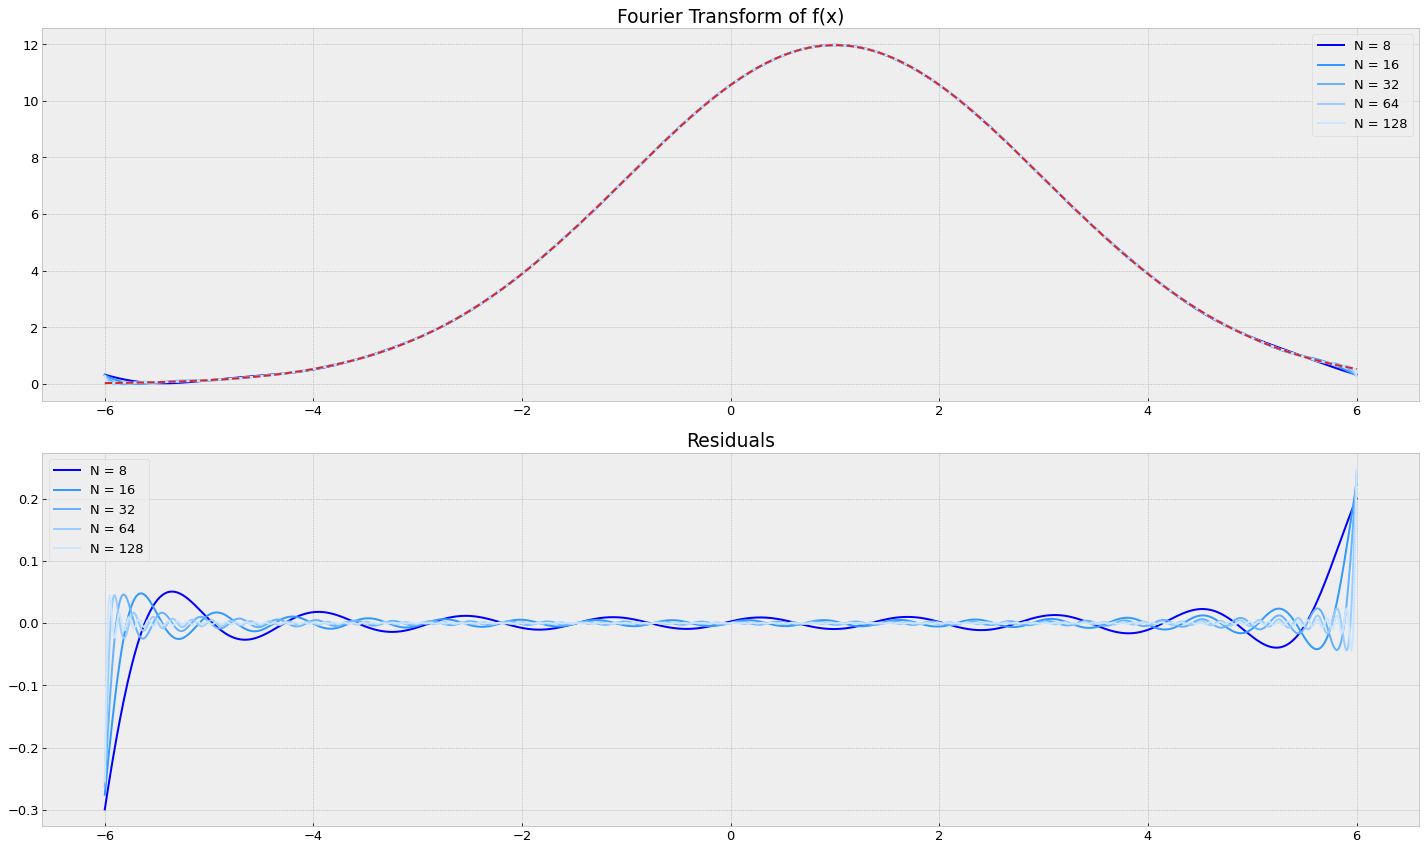

,Avg Residual
8,0.018416
16,0.010989
32,0.006390
64,0.003695
128,0.002171


In [21]:
def get_fourier_approx(f, x:np.array, a:float, b:float, N:int):
    L = b - a
    upper = L/2
    lower = - upper

    fa = lambda x, n : f(x) * cos((2*pi*n*x)/(L))
    fb = lambda x, n : f(x) * sin((2*pi*n*x)/(L))

    A0 = (1/L) * quad(f, lower, upper, limit=200)[0]

    Cosine_Sine_Sum = np.zeros_like(x)
    for n in range(1, N+1):
        A = (2/L) * quad(fa, lower, upper, args=(n), limit=200)[0]
        B = (2/L) * quad(fb, lower, upper, args=(n), limit=200)[0]
        Cosine_Sine_Sum += A*cos((2*pi*n*x)/(L)) + B*sin((2*pi*n*x)/(L))

    fx = A0 + Cosine_Sine_Sum
    return fx


mean = 6
std  = 2
f = lambda x : (1/(std*sqrt(2*pi))) * exp(-(x-1)**2/(2*std**2)) *5*12
# f = lambda x : square(x)*6
# f = lambda x : x

a = -6
b = 6
x = np.linspace(a, b, 1_000)
y = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
blue_shades = ['#0000FF', '#3399FF', '#66B2FF', '#99CCFF', '#CCE5FF']

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,y-fx, blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y-fx).mean())

ax1.set_title('Fourier Transform of f(x)')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend();ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

# Log normal distribution of $S_t$
$$\begin{align*}
& S_T &=& S_0 exp\bigg\{(r-\frac{1}{2}\sigma^2)T + \sigma\sqrt{T}Z \bigg\} &\\
& Z(S_T) &=& \frac{ln(\frac{S_T}{S_0}) - (r - \frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}} \quad &,S_T > 0 \\
& Z(S_T) &=& -\inf \quad &,S_T \le 0 \\
& f(S_T) &=& \frac{1}{\sqrt{2\pi}}exp\bigg\{-\frac{Z(S_T)^2}{2}\bigg\} &
\end{align*}$$

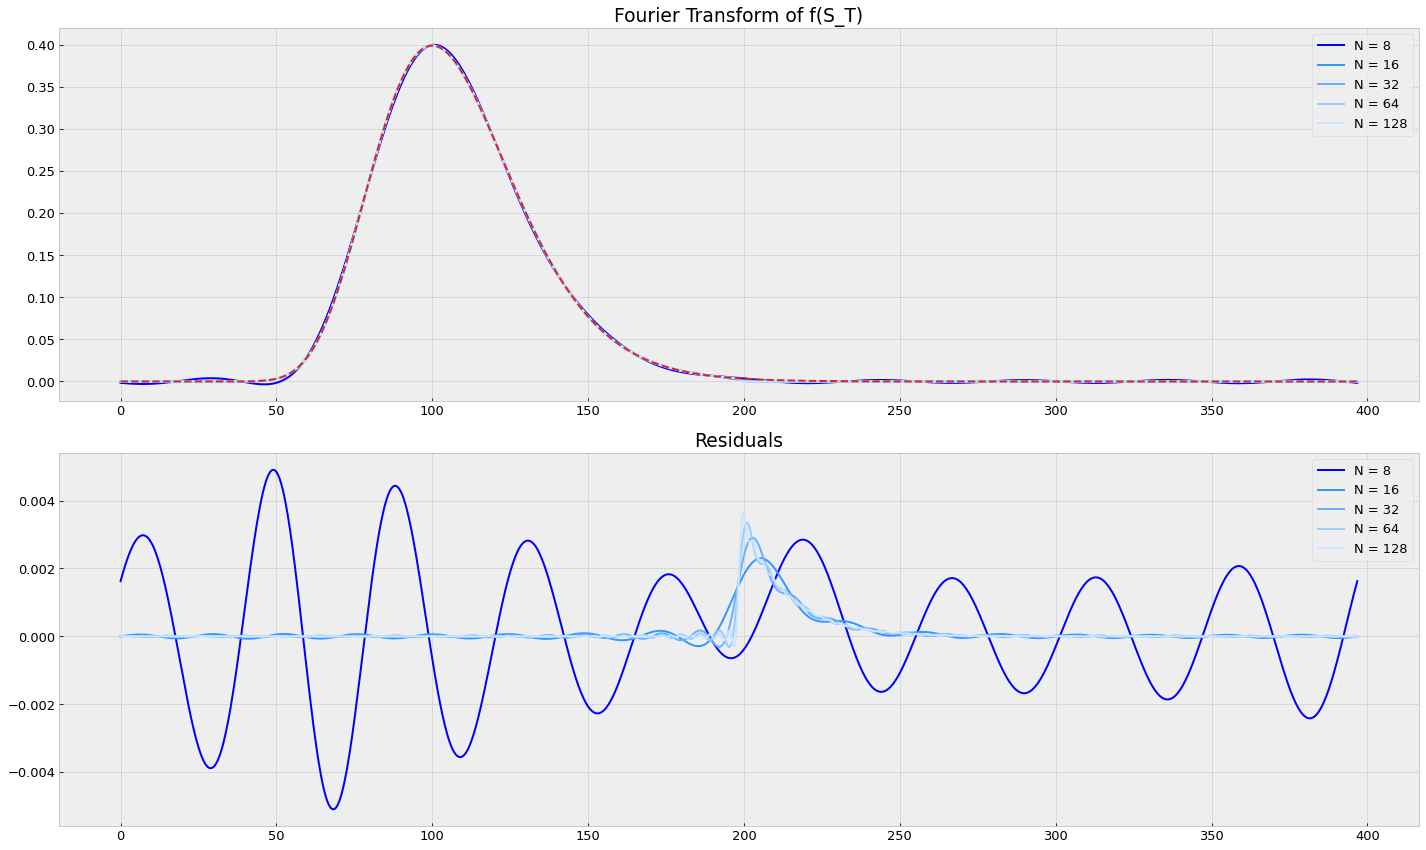

,Avg Residual
8,0.001699
16,0.000171
32,0.000151
64,0.000142
128,0.000137


In [24]:
def get_fourier_approx(f, x:np.array, a, b, N:int):
    limit =1000
    L = b - a
    upper = L/2
    lower = - upper
    # print(f"L = {L} \nupper = {upper} \nlower = {lower}")

    fa = lambda x, n : f(x) * cos((2*pi*n*x)/(L))
    fb = lambda x, n : f(x) * sin((2*pi*n*x)/(L))

    A0 = (1/L) * quad(f, lower, upper, limit=limit)[0]

    Cosine_Sine_Sum = np.zeros_like(x)
    for n in range(1, N+1):
        A = (2/L) * quad(fa, lower, upper, args=(n), limit=limit)[0]
        B = (2/L) * quad(fb, lower, upper, args=(n), limit=limit)[0]
        Cosine_Sine_Sum += A*cos((2*pi*n*x)/(L)) + B*sin((2*pi*n*x)/(L))

    fx = A0 + Cosine_Sine_Sum
    return fx


S0      = 100
K       = 100
r       = 0.05
sigma   = 0.1
T       = 5.0

Z = lambda St : np.where(St > 0, ((log(St/S0) - (r - .5*sigma)*T)/(sqrt(T)*sigma)), -np.inf)
f = lambda x : norm.pdf(Z(x)) #*2.5*12

a = 1e-8
b = S0*exp(r*T) + 12 * sigma*sqrt(T)*S0
x = np.linspace(a, b, 1_000)
y = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
blue_shades = ['#0000FF', '#3399FF', '#66B2FF', '#99CCFF', '#CCE5FF']

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,y-fx, blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y-fx).mean())

ax1.set_title('Fourier Transform of f(S_T)')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

## Timeings

In [20]:
x = np.array([100.0])
Ns = [8, 16, 32, 64, 128]
timings = []
for i, N in tqdm(enumerate(Ns), total=5):
    avg_time = []
    for _ in range(10):
        t = perf_counter()
        _ = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
        avg_time.append(perf_counter() - t)
    timings.append(np.mean(avg_time))

pd.DataFrame(timings, index=Ns, columns=['Execution Time'])

  0%|          | 0/5 [00:00<?, ?it/s]

,Execution Time
8,0.102862
16,0.242795
32,0.610726
64,1.910539
128,6.528714
